In [1]:
import sys
sys.path.append('../code/') 
import mocap_functions
from functools import partial
import numpy as np
import pandas as pd
import neo
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import signal
from scipy.interpolate import interp1d
import spike_train_functions
import elephant
import quantities as pq
# import h5py
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
import torch.nn.functional as F
from joblib import Parallel, delayed
import multiprocessing
import Neural_Decoding
import pickle
import seaborn as sns
from hnn_core.utils import smooth_waveform
#sns.set()
#sns.set_style("white")

num_cores = multiprocessing.cpu_count()
scaler = StandardScaler()

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0")
#device = torch.device('cpu')

torch.backends.cudnn.benchmark = True

In [2]:
kinematic_df, neural_df, metadata = mocap_functions.load_mocap_df('../data/SPK20220308/task_data/')
num_trials = metadata['num_trials']

#Generate cv_dict for regular train/test/validate split (no rolling window)
cv_split = ShuffleSplit(n_splits=5, test_size=.25, random_state=0)
val_split = ShuffleSplit(n_splits=1, test_size=.25, random_state=0)
cv_dict = {}
for fold, (train_val_idx, test_idx) in enumerate(cv_split.split(np.arange(num_trials))):
    for t_idx, v_idx in val_split.split(train_val_idx): #No looping, just used to split train/validation sets
        cv_dict[fold] = {'train_idx':train_val_idx[t_idx], 
                         'test_idx':test_idx, 
                         'validation_idx':train_val_idx[v_idx]} 

In [3]:
# Filter dataframes add or remove layout info
nolayout_kinematic_mask = ~(kinematic_df['name'].str.contains(pat='layout'))
noposition_kinematic_mask = ~(kinematic_df['name'].str.contains(pat='position'))
kinematic_df = kinematic_df[np.logical_and(nolayout_kinematic_mask, noposition_kinematic_mask)]

nolayout_neural_mask = ~(neural_df['unit'].str.contains(pat='layout'))
noposition_neural_mask = ~(neural_df['unit'].str.contains(pat='position'))
notask_neural_df = neural_df[np.logical_and(nolayout_neural_mask, noposition_neural_mask)]



In [4]:
def make_generators(pred_df, neural_df, neural_offset, exclude_processing=None):
    sampling_rate = 100
    kernel_offset = int(metadata['kernel_halfwidth'] * sampling_rate)  #Convolution kernel centered at zero, add to neural offset
    offset = neural_offset + kernel_offset
    window_size = 20
    data_step_size = 1

    # Set up PyTorch Dataloaders
    fold=0
    kinematic_type = 'posData'
    scale_data = True
    # Parameters
    batch_size = 10000
    train_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_cores, 'pin_memory':False}
    train_eval_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_cores, 'pin_memory':False}
    validation_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_cores, 'pin_memory':False}
    test_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_cores, 'pin_memory':False}

    predict_kinematics=True
    # Generators
    training_set = mocap_functions.SEE_Dataset(cv_dict, fold, 'train_idx', pred_df, neural_df, offset, window_size, 
                                                data_step_size, device, 'posData', scale_data, predict_kinematics, exclude_neural = exclude_processing)
    training_generator = torch.utils.data.DataLoader(training_set, **train_params)
    training_eval_generator = torch.utils.data.DataLoader(training_set, **train_eval_params)
    X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
    y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

    validation_set = mocap_functions.SEE_Dataset(cv_dict, fold, 'validation_idx', pred_df, neural_df, offset, window_size, 
                                                    data_step_size, device, 'posData', scale_data, predict_kinematics, exclude_neural = exclude_processing)
    validation_generator = torch.utils.data.DataLoader(validation_set, **validation_params)

    testing_set = mocap_functions.SEE_Dataset(cv_dict, fold, 'test_idx', pred_df, neural_df, offset, window_size, 
                                                    data_step_size, device, 'posData', scale_data, predict_kinematics, exclude_neural = exclude_processing)
    testing_generator = torch.utils.data.DataLoader(testing_set, **test_params)
    X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
    y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

    data_arrays = (training_set, validation_set, testing_set)
    generators = (training_generator, training_eval_generator, validation_generator, testing_generator)

    return data_arrays, generators 

### Use function to create train/test sets with each data frame

In [11]:
def run_wiener(pred_df, neural_df, neural_offset):
    data_arrays, generators = make_generators(pred_df, neural_df, neural_offset)

  # Unpack tuple into variables
    training_set, validation_set, testing_set = data_arrays
    training_generator, training_eval_generator, validation_generator, testing_generator = generators

    X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
    y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

    X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
    y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

    #Fit and run wiener filter
    model_wr = Neural_Decoding.decoders.WienerFilterDecoder() 
    model_wr.fit(X_train_data,y_train_data)

    wr_train_pred = model_wr.predict(X_train_data)
    wr_test_pred = model_wr.predict(X_test_data)

    #Compute decoding
    wr_train_corr = mocap_functions.matrix_corr(wr_train_pred,y_train_data)
    wr_test_corr = mocap_functions.matrix_corr(wr_test_pred,y_test_data)

    return wr_train_pred, wr_test_pred, wr_train_corr, wr_test_corr

def run_rnn(pred_df, neural_df, neural_offset):
    exclude_processing = np.zeros(len(neural_df['unit'].unique()))
    exclude_processing[-8:] = np.ones(8)
    exclude_processing = exclude_processing.astype(bool)

    data_arrays, generators = make_generators(pred_df, neural_df, neural_offset, exclude_processing)
    
    # Unpack tuple into variables
    training_set, validation_set, testing_set = data_arrays
    training_generator, training_eval_generator, validation_generator, testing_generator = generators

    X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
    y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

    X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
    y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

    #Define hyperparameters
    lr = 1e-4
    weight_decay = 1e-6
    hidden_dim = 50
    dropout = 0.1
    n_layers = 2
    max_epochs = 1000
    input_size = training_set[0][0].shape[1] 
    output_size = training_set[0][1].shape[1] 


    model_rnn = mocap_functions.model_gru(input_size, output_size, hidden_dim, n_layers, dropout, device).to(device)
    # Define Loss, Optimizerints h
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model_rnn.parameters(), lr=lr, weight_decay=weight_decay)

    #Train model
    loss_dict = mocap_functions.train_validate_model(model_rnn, optimizer, criterion, max_epochs, training_generator, validation_generator, device, 10, 5)

    #Evaluate trained model
    rnn_train_pred = mocap_functions.evaluate_model(model_rnn, training_eval_generator, device)
    rnn_test_pred = mocap_functions.evaluate_model(model_rnn, testing_generator, device)

    #Evaluate trained model
    rnn_train_pred = mocap_functions.evaluate_model(model_rnn, training_eval_generator, device)
    rnn_test_pred = mocap_functions.evaluate_model(model_rnn, testing_generator, device)

    rnn_train_corr = mocap_functions.matrix_corr(rnn_train_pred, y_train_data)
    rnn_test_corr = mocap_functions.matrix_corr(rnn_test_pred, y_test_data)

    return rnn_train_pred, rnn_test_pred, rnn_train_corr, rnn_test_corr
    

### Generate decoding results

In [12]:
carpal_df = kinematic_df[kinematic_df['name'].str.contains(pat='carpal')]
carpal_df['posData'] = carpal_df['posData'].map(partial(smooth_waveform, window_len=200, sfreq=100))

func_dict = {'wiener': run_wiener, 'rnn': run_rnn}
df_dict = {'layout': neural_df, 'nolayout': notask_neural_df}
decode_results = dict()
for func_name, func in func_dict.items():
    decode_results[func_name] = dict()
    for df_type, pred_df in df_dict.items():
        train_pred, test_pred, train_corr, test_corr = func(carpal_df, pred_df, 20)

        decode_results[func_name][df_type] = {
            'train_pred': train_pred,
            'test_pred': test_pred,
            'train_corr': train_corr,
            'test_corr': test_corr
        }



/tmp/ipykernel_27029/3394839204.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  carpal_df['posData'] = carpal_df['posData'].map(partial(smooth_waveform, window_len=200, sfreq=100))


**********
Epoch: 10/1000 ... Train Loss: 0.7331  ... Validation Loss: 0.7106
*********.
Epoch: 20/1000 ... Train Loss: 0.6084  ... Validation Loss: 0.6022
*.*..*.*.*
Epoch: 30/1000 ... Train Loss: 0.5659  ... Validation Loss: 0.5453
*.***.**..
Epoch: 40/1000 ... Train Loss: 0.5311  ... Validation Loss: 0.5264
.*.*....*.
Epoch: 50/1000 ... Train Loss: 0.4998  ... Validation Loss: 0.5078
*....*...*
Epoch: 60/1000 ... Train Loss: 0.4786  ... Validation Loss: 0.4856
*...*..*..
Epoch: 70/1000 ... Train Loss: 0.4518  ... Validation Loss: 0.4822
.*.*..**..
Epoch: 80/1000 ... Train Loss: 0.4685  ... Validation Loss: 0.4769
*.*...... Early Stop; Min Epoch: 83
**********
Epoch: 10/1000 ... Train Loss: 0.7853  ... Validation Loss: 0.7870
.***.*****
Epoch: 20/1000 ... Train Loss: 0.6901  ... Validation Loss: 0.6929
**.*******
Epoch: 30/1000 ... Train Loss: 0.6095  ... Validation Loss: 0.5996
.*.**.**..
Epoch: 40/1000 ... Train Loss: 0.5356  ... Validation Loss: 0.5444
..*.**..*.
Epoch: 50/1000 ..

In [19]:
carpal_df = kinematic_df[kinematic_df['name'].str.contains(pat='carpal')]
exclude_processing = np.zeros(95)
exclude_processing[-8:] = np.ones(8)
exclude_processing = exclude_processing.astype(bool)

data_arrays, generators = make_generators(carpal_df, neural_df, 20, exclude_processing)

# Unpack tuple into variables
training_set, validation_set, testing_set = data_arrays
training_generator, training_eval_generator, validation_generator, testing_generator = generators

X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

In [24]:
X_train_data[1000,-14:]

array([-1.09162287, -0.40834168,  1.18526129, -1.18886704, -0.09385511,
       -0.20353861,  0.        ,  0.        ,  1.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ])

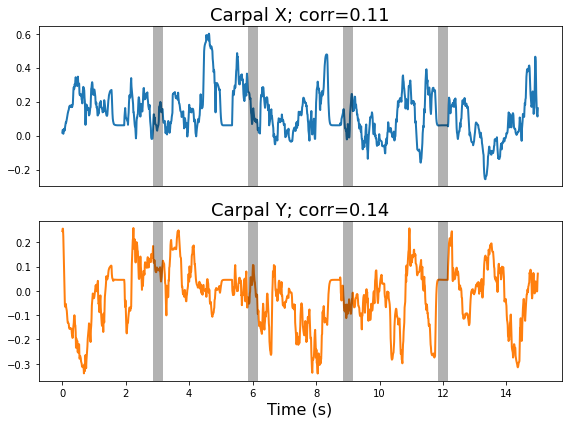

In [10]:
plt.figure(figsize=(8, 6))
tstart = 1800
bounds = np.arange(tstart, tstart + 1500)
x_vals = np.arange(len(bounds))/100

marker_names = ['Carpal X', 'Carpal Y', 'Carpal Z']
for col_idx in range(2):
    plt.subplot(2, 1, col_idx+1)
    #plt.plot(x_vals, y_test_data[bounds, col_idx], color='k')
    plt.plot(x_vals, decode_results['rnn']['layout']['test_pred'][bounds, col_idx], color=f'C{col_idx + 0}', linewidth=2)
    plt.title(f"{marker_names[col_idx]}; corr={np.round(decode_results['rnn']['layout']['test_corr'][col_idx], 2)}", fontsize=18)
    
    if col_idx == 1:
        plt.xlabel('Time (s)', fontsize=16)
    else:
        plt.xticks([])
    
    plt.ylim(plt.ylim())
    plt.xlim(plt.xlim())
    
    plt.vlines(x=[3, 6, 9, 12],ymin=-10, ymax=10, color='k', linewidth=10, linestyle='-', alpha=0.3)
plt.tight_layout()
plt.savefig(f'movement_decoding_final.svg')

(-0.05, 0.9)

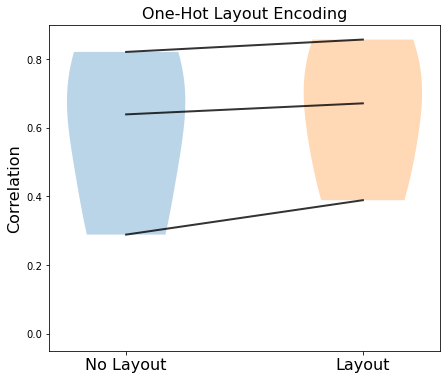

In [13]:
nolayout_test_corr = decode_results['rnn']['nolayout']['test_corr']
all_test_corr = decode_results['rnn']['layout']['test_corr']

plt.figure(figsize=(7,6))
plot_data = np.stack([nolayout_test_corr, all_test_corr])
_ = plt.plot(plot_data, color='k', linewidth=2, alpha=0.8)
plt.xticks([0, 1], labels=['No Layout', 'Layout'], fontsize=16)
plt.ylabel('Correlation', fontsize=16)
plt.violinplot(nolayout_test_corr, positions=[0], showmeans=False,showextrema=False)
plt.violinplot(all_test_corr, positions=[1], showmeans=False,showextrema=False)
plt.title('One-Hot Layout Encoding', fontsize=16)
plt.ylim([-0.05,0.9])

In [ ]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plot_data = np.stack([proxjoint_test_corr, all_test_corr, finger_test_corr])
_ = plt.plot(plot_data, color='k', linewidth=2, alpha=0.8)
plt.xticks([0, 1, 2], labels=['ProxJoint', 'Combined', 'Finger'], fontsize=16)
plt.ylabel('Correlation', fontsize=16)
plt.violinplot(proxjoint_test_corr, positions=[0], showmeans=False,showextrema=False)
plt.violinplot(all_test_corr, positions=[1], showmeans=False,showextrema=False)
plt.violinplot(finger_test_corr, positions=[2], showmeans=False,showextrema=False)
plt.title('ProxJoint/Finger vs. Combined', fontsize=16)
plt.ylim([-0.05,0.9])

plt.subplot(1,2,2)
plot_data = np.stack([finger_proxjoint_test_corr, all_test_corr, eyes_test_corr])
_ = plt.plot(plot_data, color='k', linewidth=2, alpha=0.8)
plt.xticks([0, 1, 2], labels=['Finger+ProxJoint', 'Combined', 'Eyes'], fontsize=16)
plt.ylabel('Correlation', fontsize=16)
plt.violinplot(finger_proxjoint_test_corr, positions=[0], showmeans=False,showextrema=False)
plt.violinplot(all_test_corr, positions=[1], showmeans=False,showextrema=False)
plt.violinplot(eyes_test_corr, positions=[2], showmeans=False,showextrema=False)
plt.title('Finger+ProxJoint/Eyes vs. Combined', fontsize=16)
plt.ylim([-0.05,0.9])

plt.savefig('single_unit_pred_final.svg')

In [ ]:
compare_data_list = [all_test_pred, eyes_test_pred, finger_test_pred, proxjoint_test_pred]
compare_data_names = ['Combined', 'Eyes', 'Fingers', 'Forelimb']

data_arrays, generators = make_generators(kinematic_df, neural_df, neural_offset=20)
    
# Unpack tuple into variables
training_set, validation_set, testing_set = data_arrays
training_generator, training_eval_generator, validation_generator, testing_generator = generators

X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

#Testing Data
plt.figure(figsize=(14,8))
bounds = np.arange(0,1500)
x_vals = np.arange(len(bounds))/100
unit_list = [4, 8, 16]

for row_idx, unit_idx in enumerate(unit_list):
    for plot_idx, (compare_data, name) in enumerate(zip(compare_data_list, compare_data_names)):
        plt.subplot(3,4, plot_idx+1 + (4*row_idx))
        plt.plot(x_vals, y_test_data[bounds,unit_idx], color='k')
        plt.ylim(plt.ylim())
        plt.plot(x_vals, compare_data[bounds,unit_idx], color=f'C{plot_idx + 1}')
        plt.title(f'{name}: Unit {unit_idx}')
        #plt.ylim([-3, 3.7])
        
        if plot_idx == 0:
            plt.ylabel('Firing Rate (a.u.)')
            
        if row_idx == 2:
            plt.xlabel('Time (s)')
        else:
            plt.xticks([])

    plt.tight_layout()